In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.8.0+cu126
2.8.0+cpu


In [5]:
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio

# Audio input/output

In [7]:
from torchaudio.utils import download_asset

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")


def _hide_seek(obj):
    class _wrapper:
        def __init__(self, obj):
            self.obj = obj

        def read(self, n):
            return self.obj.read(n)

    return _wrapper(obj)

C:\Users\phy00\AppData\Local\Temp\ipykernel_37064\360453789.py:3: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
100.0%
C:\Users\phy00\AppData\Local\Temp\ipykernel_37064\360453789.py:4: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
100.0%
C:\Users\phy00\AppData\Local\Temp\ipykernel_37064\360453789.py:5: Use

In [13]:
# Load .m4a files from audio_dataset directory
import glob
from pathlib import Path

# Define the dataset directory path
DATASET_DIR = Path("audio_dataset")

# Find all .m4a files in the dataset directory
m4a_files = list(DATASET_DIR.glob("*.m4a"))
print(f"Found {len(m4a_files)} .m4a files:")
for file in m4a_files:
    print(f"  - {file}")

# Load the first .m4a file as an example
if m4a_files:
    SAMPLE_M4A = str(m4a_files[0])  # Convert Path to string for torchaudio
    print(f"\nLoading: {SAMPLE_M4A}")
    
    try:
        # Get metadata info for the .m4a file
        metadata = torchaudio.info(SAMPLE_M4A)
        print(f"Metadata: {metadata}")
        
        # Load the audio waveform and sample rate
        waveform, sample_rate = torchaudio.load(SAMPLE_M4A)
        print(f"Waveform shape: {waveform.shape}")
        print(f"Sample rate: {sample_rate} Hz")
        print(f"Duration: {waveform.shape[1] / sample_rate:.2f} seconds")
        
    except Exception as e:
        print(f"Error loading .m4a file: {e}")
        print("Note: .m4a format requires ffmpeg backend. Make sure ffmpeg is installed.")
else:
    print("No .m4a files found in the dataset directory")

Found 4 .m4a files:
  - audio_dataset\095522039.m4a
  - audio_dataset\095522040.m4a
  - audio_dataset\095522041.m4a
  - audio_dataset\095522042.m4a

Loading: audio_dataset\095522039.m4a
Error loading .m4a file: Couldn't find appropriate backend to handle uri audio_dataset\095522039.m4a and format None.
Note: .m4a format requires ffmpeg backend. Make sure ffmpeg is installed.


C:\Users\phy00\AppData\Local\Temp\ipykernel_37064\3481972473.py:21: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(SAMPLE_M4A)


In [14]:
# Set up ffmpeg backend for .m4a file support
import torchaudio
import warnings

# Set the backend to ffmpeg to support .m4a files
try:
    torchaudio.set_audio_backend("ffmpeg")
    print("✓ Successfully set audio backend to ffmpeg")
except Exception as e:
    print(f"Failed to set ffmpeg backend: {e}")
    print("Trying soundfile backend as alternative...")
    try:
        torchaudio.set_audio_backend("soundfile")
        print("✓ Successfully set audio backend to soundfile")
    except Exception as e2:
        print(f"Failed to set soundfile backend: {e2}")
        print("You may need to install ffmpeg or soundfile for .m4a support")

# Check current backend
print(f"Current audio backend: {torchaudio.get_audio_backend()}")

# Suppress deprecation warnings for now
warnings.filterwarnings("ignore", category=UserWarning, module="torchaudio")

✓ Successfully set audio backend to ffmpeg
Current audio backend: None


C:\Users\phy00\AppData\Local\Temp\ipykernel_37064\192650183.py:7: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.set_audio_backend("ffmpeg")
c:\Users\phy00\anaconda3\envs\ai_lab\lib\site-packages\torchaudio\_internal\module_utils.py:71: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  return func(*args, **kwargs)
C:\Users\phy00\AppData\Local\Temp\ipykernel_37064\192650183.py:20: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. This deprecation is part of a large refactoring effort to t

In [15]:
# Try loading .m4a files again with updated approach
import os

# Load the first .m4a file
if m4a_files:
    SAMPLE_M4A = str(m4a_files[0])
    print(f"Attempting to load: {SAMPLE_M4A}")
    
    # Check if file exists
    if os.path.exists(SAMPLE_M4A):
        print(f"✓ File exists, size: {os.path.getsize(SAMPLE_M4A)} bytes")
        
        try:
            # Try loading with torchaudio (should auto-detect appropriate backend)
            waveform, sample_rate = torchaudio.load(SAMPLE_M4A)
            print(f"✓ Successfully loaded .m4a file!")
            print(f"Waveform shape: {waveform.shape}")
            print(f"Sample rate: {sample_rate} Hz")
            print(f"Duration: {waveform.shape[1] / sample_rate:.2f} seconds")
            print(f"Number of channels: {waveform.shape[0]}")
            
            # Store the loaded audio for later use
            m4a_waveform = waveform
            m4a_sample_rate = sample_rate
            
        except Exception as e:
            print(f"❌ Error loading .m4a file: {e}")
            print("This might require additional audio codecs or ffmpeg installation")
            
            # Alternative: suggest conversion to supported format
            print("\nAlternative solutions:")
            print("1. Install ffmpeg: conda install ffmpeg")
            print("2. Convert .m4a to .wav using external tools")
            print("3. Use other audio processing libraries like librosa")
    else:
        print(f"❌ File not found: {SAMPLE_M4A}")
else:
    print("No .m4a files found")

Attempting to load: audio_dataset\095522039.m4a
✓ File exists, size: 27250 bytes
❌ Error loading .m4a file: Couldn't find appropriate backend to handle uri audio_dataset\095522039.m4a and format None.
This might require additional audio codecs or ffmpeg installation

Alternative solutions:
1. Install ffmpeg: conda install ffmpeg
2. Convert .m4a to .wav using external tools
3. Use other audio processing libraries like librosa


In [16]:
# Alternative approach: Use librosa to load .m4a files
try:
    import librosa
    import numpy as np
    print("✓ librosa is available")
    
    # Load .m4a file using librosa
    if m4a_files:
        SAMPLE_M4A = str(m4a_files[0])
        print(f"Loading {SAMPLE_M4A} with librosa...")
        
        try:
            # Load with librosa (supports many formats including .m4a)
            audio_data, sr = librosa.load(SAMPLE_M4A, sr=None)  # sr=None preserves original sample rate
            print(f"✓ Successfully loaded with librosa!")
            print(f"Audio shape: {audio_data.shape}")
            print(f"Sample rate: {sr} Hz")
            print(f"Duration: {len(audio_data) / sr:.2f} seconds")
            
            # Convert to PyTorch tensor for compatibility with torchaudio functions
            m4a_waveform = torch.from_numpy(audio_data).unsqueeze(0)  # Add channel dimension
            m4a_sample_rate = sr
            
            print(f"✓ Converted to PyTorch tensor: {m4a_waveform.shape}")
            print(f"Data type: {m4a_waveform.dtype}")
            
            # Now you can use this with torchaudio functions
            print("\n🎉 .m4a file successfully loaded and ready for use with PyTorch/torchaudio!")
            
        except Exception as e:
            print(f"❌ Error loading with librosa: {e}")
            
except ImportError:
    print("❌ librosa not installed. Installing...")
    
    # Try to install librosa
    import subprocess
    import sys
    
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "librosa"])
        print("✓ librosa installed successfully. Please restart the kernel and try again.")
    except Exception as e:
        print(f"❌ Failed to install librosa: {e}")
        print("Please install manually: pip install librosa")

❌ librosa not installed. Installing...
✓ librosa installed successfully. Please restart the kernel and try again.


In [17]:
# Import librosa and load .m4a files
import librosa
import numpy as np

print("✓ librosa imported successfully")

# Load all .m4a files from the dataset
m4a_audio_data = {}

for i, m4a_file in enumerate(m4a_files):
    file_path = str(m4a_file)
    print(f"\nLoading file {i+1}/{len(m4a_files)}: {file_path}")
    
    try:
        # Load audio with librosa
        audio_data, sr = librosa.load(file_path, sr=None)
        
        # Convert to PyTorch tensor for torchaudio compatibility
        waveform_tensor = torch.from_numpy(audio_data).unsqueeze(0).float()
        
        # Store in dictionary
        filename = m4a_file.name
        m4a_audio_data[filename] = {
            'waveform': waveform_tensor,
            'sample_rate': sr,
            'duration': len(audio_data) / sr,
            'shape': waveform_tensor.shape
        }
        
        print(f"  ✓ Shape: {waveform_tensor.shape}")
        print(f"  ✓ Sample rate: {sr} Hz")
        print(f"  ✓ Duration: {len(audio_data) / sr:.2f} seconds")
        
    except Exception as e:
        print(f"  ❌ Error loading {file_path}: {e}")

print(f"\n🎉 Successfully loaded {len(m4a_audio_data)} .m4a files!")
print("Available files:")
for filename, info in m4a_audio_data.items():
    print(f"  - {filename}: {info['shape']}, {info['duration']:.2f}s")

✓ librosa imported successfully

Loading file 1/4: audio_dataset\095522039.m4a


C:\Users\phy00\AppData\Local\Temp\ipykernel_37064\2222308205.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path, sr=None)
c:\Users\phy00\anaconda3\envs\ai_lab\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  ✓ Shape: torch.Size([1, 177152])
  ✓ Sample rate: 44100 Hz
  ✓ Duration: 4.02 seconds

Loading file 2/4: audio_dataset\095522040.m4a
  ✓ Shape: torch.Size([1, 177152])
  ✓ Sample rate: 44100 Hz
  ✓ Duration: 4.02 seconds

Loading file 3/4: audio_dataset\095522041.m4a


C:\Users\phy00\AppData\Local\Temp\ipykernel_37064\2222308205.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path, sr=None)
c:\Users\phy00\anaconda3\envs\ai_lab\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  ✓ Shape: torch.Size([1, 177152])
  ✓ Sample rate: 44100 Hz
  ✓ Duration: 4.02 seconds

Loading file 4/4: audio_dataset\095522042.m4a
  ✓ Shape: torch.Size([1, 177152])
  ✓ Sample rate: 44100 Hz
  ✓ Duration: 4.02 seconds

🎉 Successfully loaded 4 .m4a files!
Available files:
  - 095522039.m4a: torch.Size([1, 177152]), 4.02s
  - 095522040.m4a: torch.Size([1, 177152]), 4.02s
  - 095522041.m4a: torch.Size([1, 177152]), 4.02s
  - 095522042.m4a: torch.Size([1, 177152]), 4.02s


Using 095522039.m4a for demonstration:
Waveform shape: torch.Size([1, 177152])
Sample rate: 44100 Hz

✓ Ready to use with existing functions:
  - plot_waveform(demo_waveform, demo_sample_rate)
  - plot_specgram(demo_waveform, demo_sample_rate)
  - Audio(demo_waveform.numpy()[0], rate=demo_sample_rate)

Plotting waveform for 095522039.m4a...


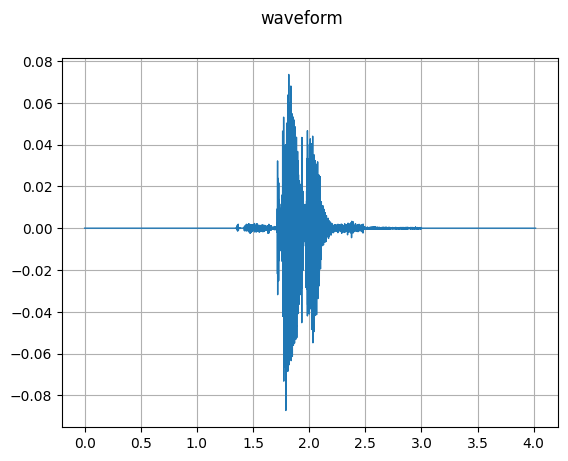

In [20]:
# Use the loaded .m4a data with existing torchaudio functions
# Select the first loaded file for demonstration
first_file = list(m4a_audio_data.keys())[0]
demo_waveform = m4a_audio_data[first_file]['waveform']
demo_sample_rate = m4a_audio_data[first_file]['sample_rate']

print(f"Using {first_file} for demonstration:")
print(f"Waveform shape: {demo_waveform.shape}")
print(f"Sample rate: {demo_sample_rate} Hz")

# Now you can use this with the existing plot functions
print("\n✓ Ready to use with existing functions:")
print("  - plot_waveform(demo_waveform, demo_sample_rate)")
print("  - plot_specgram(demo_waveform, demo_sample_rate)")
print("  - Audio(demo_waveform.numpy()[0], rate=demo_sample_rate)")

# Example: Plot the waveform of the first .m4a file
print(f"\nPlotting waveform for {first_file}...")
plot_waveform(demo_waveform, demo_sample_rate)

Plotting spectrogram...


c:\Users\phy00\anaconda3\envs\ai_lab\lib\site-packages\matplotlib\axes\_axes.py:8283: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


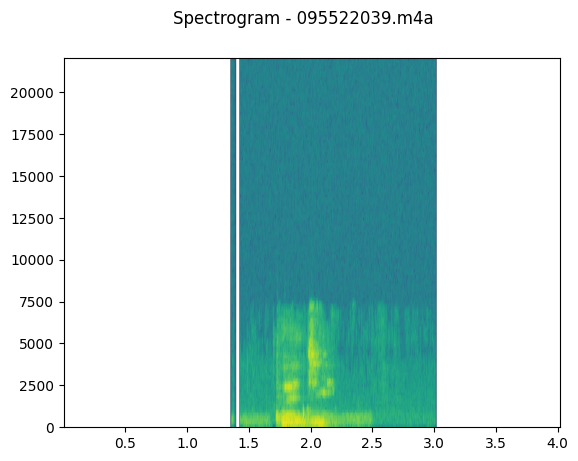

In [22]:
# Plot spectrogram and play audio for the .m4a file
print("Plotting spectrogram...")
plot_specgram(demo_waveform, demo_sample_rate, title=f"Spectrogram - {first_file}")

In [23]:
# Create audio player for the .m4a file
print("Creating audio player...")
Audio(demo_waveform.numpy()[0], rate=demo_sample_rate)

Creating audio player...


In [19]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)


In [ ]:
plot_waveform(waveform, sample_rate)

In [21]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

In [ ]:
plot_specgram(waveform, sample_rate)

In [ ]:
Audio(waveform.numpy()[0], rate=sample_rate)

# Audio resampling

In [1]:
import torchaudio.functional as F
import torchaudio.transforms as T

## preparation

## Performance benchmarking
### Downsample (16 - 8 kHz)
### Upsample (8 - 16 kHz)

# Audio Feature Extraction

In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.8.0+cu126
2.8.0+cpu


In [10]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    im = ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Power (dB)', rotation=270, labelpad=15)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

C:\Users\phy00\AppData\Local\Temp\ipykernel_21464\3725973245.py:7: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


In [3]:
# Load audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

c:\Users\phy00\anaconda3\envs\ai_lab\lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


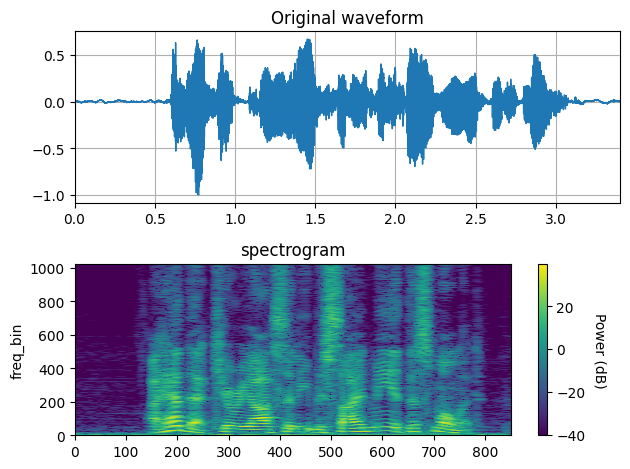

In [11]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [5]:
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

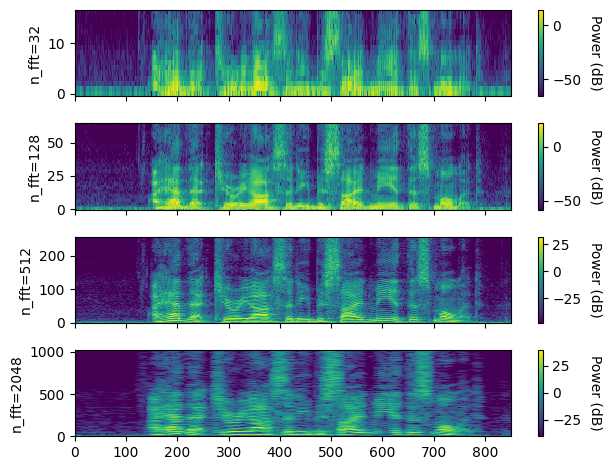

In [12]:
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(SPEECH_WAVEFORM)
    specs.append(spec)
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

In [7]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM, SAMPLE_RATE, SAMPLE_RATE // 2)
# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE // 2, SAMPLE_RATE)

In [8]:
# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(SPEECH_WAVEFORM)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)

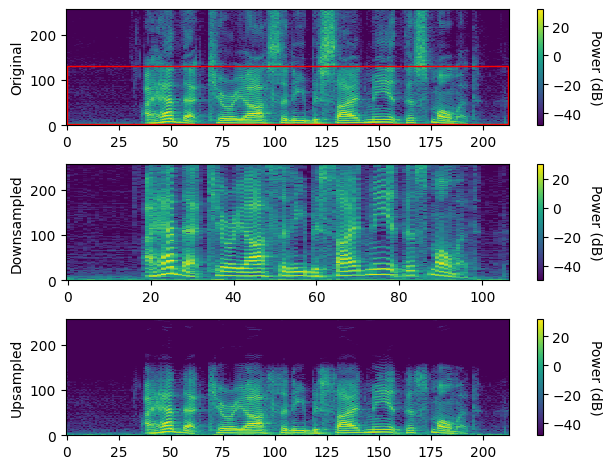

In [13]:
# Visualize it
fig, axs = plt.subplots(3, 1)
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])
fig.tight_layout()

## GriffinLim

In [14]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(SPEECH_WAVEFORM)
reconstructed_waveform = griffin_lim(spec)

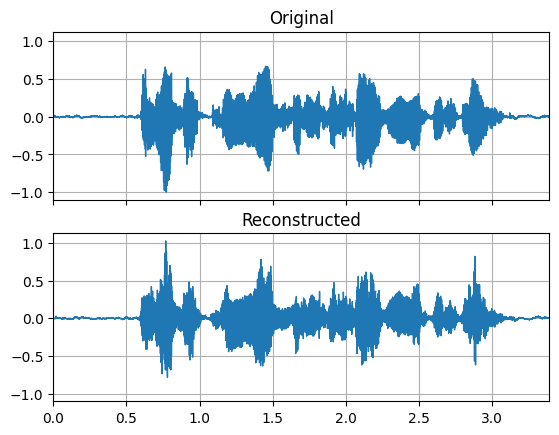

In [15]:
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

## Mel Filter Bank

In [16]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

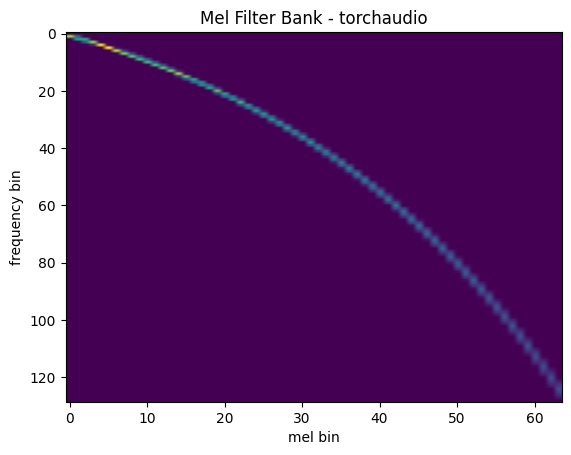

In [17]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

Mean Square Difference:  3.9649698287757504e-17


C:\Users\phy00\AppData\Local\Temp\ipykernel_21464\3559595193.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.square(mel_filters - mel_filters_librosa).mean().item()


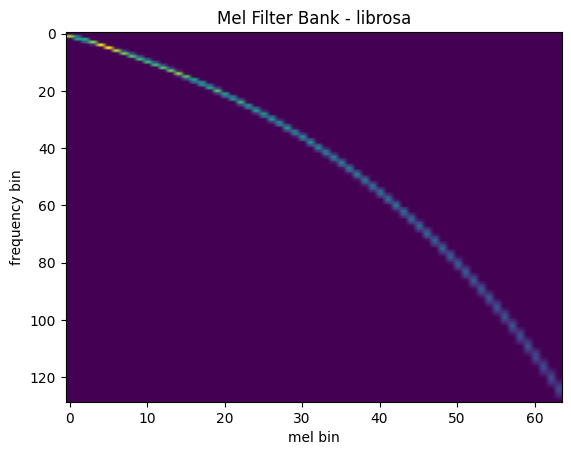

In [19]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

## MelSpectrogram

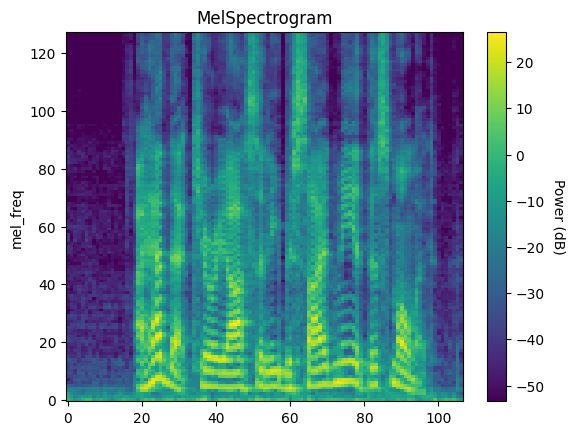

In [20]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

plot_spectrogram(melspec[0], title="MelSpectrogram", ylabel="mel_freq")

In [21]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

Mean Square Difference:  1.2877707789016313e-09


C:\Users\phy00\AppData\Local\Temp\ipykernel_21464\2206006589.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.square(melspec - melspec_librosa).mean().item()


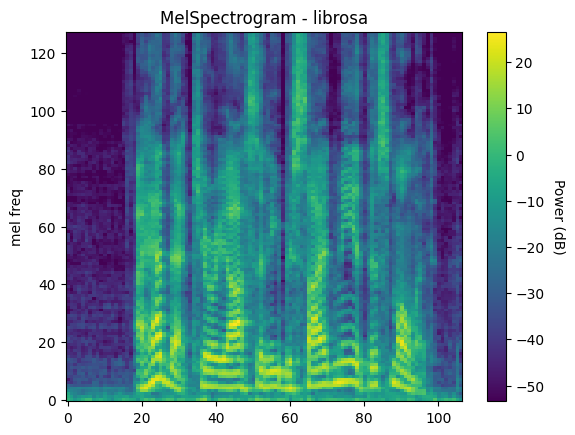

In [22]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)